In [1]:
import pandas as pd
import numpy as np

# 可視化用のライブラリ
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

# import neologdn
# import MeCab

import re

from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
# # プログレスバーのラベル設定
tqdm_notebook.pandas(desc="progress: ")

#前処理用ライブラリ
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# 機械学習モデル関連ライブラリ
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn import neighbors


# モデル評価関連ライブラリ
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc, roc_curve

from sklearn.decomposition import PCA #主成分分析器

## 標準偏差のみで絞った単語を特徴量にしたときのモデル精度を算出

## 教師データ紐付け
#### まずは教師データ＆文書歯抜けデータに[内容_id]カラムを付与するために元ファイル(全文書あり)と連結させる

In [2]:
# 教師データ歯抜けファイル（教師データが紐づいていない文書が抜けているデータフレーム）読み込み
df = pd.read_pickle('posi_nega_discretedata.pkl')
df.head()

,text,posi_nega
0,案件個別の技術相談乗ってます！乗ります,1
1,勉強とお仕事が有機的に繋がっていて面白い。,1
2,次々とテクニックを教えていただき、ためになりました,1
3,お肉がキレイに焼けたことに小さなしあわせを感じた,1
4,これが私の最適化,1


In [3]:
# 元ファイル(全文書あり)読み込み
raw_df = pd.read_pickle('posi_nega_alldata.pkl')
raw_df.head()

,text,posi_nega
0,案件個別の技術相談乗ってます！乗ります,1
1,勉強とお仕事が有機的に繋がっていて面白い。,1
2,次々とテクニックを教えていただき、ためになりました,1
3,お肉がキレイに焼けたことに小さなしあわせを感じた,1
4,これが私の最適化,1


In [4]:
# 元ファイルに内容_idカラムを追加する
raw_df['内容_id'] = range(len(raw_df))
# [posi_nega]カラムは必要ないので除外
raw_df = raw_df[['text', '内容_id']]
raw_df.head()

,text,内容_id
0,案件個別の技術相談乗ってます！乗ります,0
1,勉強とお仕事が有機的に繋がっていて面白い。,1
2,次々とテクニックを教えていただき、ためになりました,2
3,お肉がキレイに焼けたことに小さなしあわせを感じた,3
4,これが私の最適化,4


In [5]:
# 歯抜けファイルと元ファイルを[text]をキーにして紐付け
# 歯抜けファイルをpd.merge関数の第一引数に与える
merge_df = pd.merge(df, raw_df, on='text', how='left')
merge_df.head()

# [内容_id]カラムの紐付け完了

,text,posi_nega,内容_id
0,案件個別の技術相談乗ってます！乗ります,1,0
1,勉強とお仕事が有機的に繋がっていて面白い。,1,1
2,次々とテクニックを教えていただき、ためになりました,1,2
3,お肉がキレイに焼けたことに小さなしあわせを感じた,1,3
4,これが私の最適化,1,4


In [6]:
merge_df.shape

(40, 3)

In [7]:
merge_df.isnull().sum()

text         0
posi_nega    0
内容_id        0
dtype: int64

### ここで教師データを全内容ID×単語のデータフレームと連結させる

In [8]:
# 全内容ID×単語のデータフレームを読み込み
std001_model_tfidf_df = pd.read_pickle('std001_model_tfidf_df.pkl')
std001_model_tfidf_df.head()

original_type,以上_名詞-非自立-副詞可能,と_助詞-格助詞-引用,・_記号-一般,気_名詞-非自立-一般,これ_名詞-代名詞-一般,悪い_形容詞-自立,いう_動詞-自立,で_助詞-格助詞-一般,てる_動詞-非自立,ずっと_副詞-一般,...,ある_助動詞,から_助詞-接続助詞,事_名詞-非自立-一般,が_助詞-接続助詞,として_助詞-格助詞-連語,業務_名詞-一般,変わる_動詞-自立,で_助詞-接続助詞,悩む_動詞-自立,ので_助詞-接続助詞
内容_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.705146,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# このままだと[内容_id]がカラムではなくインデックスのままなので
# [内容_id]カラムをインデックスから列側に移動させる
std001_model_tfidf_df = std001_model_tfidf_df.reset_index()
std001_model_tfidf_df.head()

original_type,内容_id,以上_名詞-非自立-副詞可能,と_助詞-格助詞-引用,・_記号-一般,気_名詞-非自立-一般,これ_名詞-代名詞-一般,悪い_形容詞-自立,いう_動詞-自立,で_助詞-格助詞-一般,てる_動詞-非自立,...,ある_助動詞,から_助詞-接続助詞,事_名詞-非自立-一般,が_助詞-接続助詞,として_助詞-格助詞-連語,業務_名詞-一般,変わる_動詞-自立,で_助詞-接続助詞,悩む_動詞-自立,ので_助詞-接続助詞
0,0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.705146,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# 内容_idをキーにしてデータフレームを連結
# 教師データがあるデータフレーム(df)をpd.merge関数の第一引数に与える
model_merge_id_df = pd.merge(merge_df, std001_model_tfidf_df, on='内容_id', how='left')
model_merge_id_df.head()

,text,posi_nega,内容_id,以上_名詞-非自立-副詞可能,と_助詞-格助詞-引用,・_記号-一般,気_名詞-非自立-一般,これ_名詞-代名詞-一般,悪い_形容詞-自立,いう_動詞-自立,...,ある_助動詞,から_助詞-接続助詞,事_名詞-非自立-一般,が_助詞-接続助詞,として_助詞-格助詞-連語,業務_名詞-一般,変わる_動詞-自立,で_助詞-接続助詞,悩む_動詞-自立,ので_助詞-接続助詞
0,案件個別の技術相談乗ってます！乗ります,1,0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,勉強とお仕事が有機的に繋がっていて面白い。,1,1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,次々とテクニックを教えていただき、ためになりました,1,2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,お肉がキレイに焼けたことに小さなしあわせを感じた,1,3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,これが私の最適化,1,4,0.0,0.0,0.0,0.0,0.705146,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
model_merge_id_df.isnull().any()

text               False
posi_nega          False
内容_id              False
以上_名詞-非自立-副詞可能     False
と_助詞-格助詞-引用        False
・_記号-一般            False
気_名詞-非自立-一般        False
これ_名詞-代名詞-一般       False
悪い_形容詞-自立          False
いう_動詞-自立           False
で_助詞-格助詞-一般        False
てる_動詞-非自立          False
ずっと_副詞-一般          False
に_助詞-副詞化           False
くる_動詞-非自立          False
できる_動詞-自立          False
ます_助動詞             False
って_助詞-格助詞-連語       False
だ_助動詞              False
考える_動詞-自立          False
時間_名詞-副詞可能         False
おかげ_名詞-一般          False
いる_動詞-自立           False
何_名詞-代名詞-一般        False
..._記号-一般          False
案件_名詞-一般           False
する_動詞-自立           False
は_助詞-係助詞           False
いただく_動詞-非自立        False
こと_名詞-非自立-一般       False
                   ...  
なる_動詞-自立           False
や_助詞-並立助詞          False
よう_名詞-非自立-助動詞語幹    False
、_記号-読点            False
お_接頭詞-名詞接続         False
とても_副詞-助詞類接続       False
さ_名詞-接尾-特殊         False
読む_動詞-自立           False
みんな_名詞-代名詞-一般      False


In [12]:
model_merge_id_df.shape

(40, 80)

## 学習データとテストデータに分割

In [13]:
# 順番注意：train_X, test_X, train_y, test_y
# [\](バックスラッシュ)はMacの場合[option(alt)]+[¥]を入力
train_X, test_X, train_y, test_y = \
train_test_split(model_merge_id_df.drop(['text', '内容_id', 'posi_nega'], axis=1),\
                 model_merge_id_df['posi_nega'], test_size=0.2, random_state=0)
print(train_X.shape)
print(test_X.shape)
print(train_y.shape)
print(test_y.shape)

(32, 77)
(8, 77)
(32,)
(8,)


## モデル作成
今回はランダムフォレストを使用し、パラメータ調整はしない

In [14]:
clf = RandomForestClassifier(n_jobs=-1, n_estimators=30)# 今回はmax_depth=30を除外

## 学習

In [15]:
clf.fit(train_X, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## 予測

In [16]:
pred_y = clf.predict(test_X)
pred_y

array([0, 1, 1, 0, 1, 1, 1, 1], dtype=int64)

## 正解率・適合率・再現率・F値を算出

In [17]:
# 混同行列を出力

confusion_matrix(test_y, pred_y)
tn, fp, fn, tp = confusion_matrix(test_y, pred_y).ravel()
# (tp, fn, fp, tn)に順番を変更、それを行列にする
print(np.array([[tp, fn], [fp, tn]]))
print('--------------------------------')
# 二次元配列の場合はnumpy.matrix関数でも表現可能
print(np.matrix([[tp, fn], [fp, tn]]))

[[2 1]
 [4 1]]
--------------------------------
[[2 1]
 [4 1]]


In [18]:
# 参考URL：https://pythondatascience.plavox.info/scikit-learn/%E5%88%86%E9%A1%9E%E7%B5%90%E6%9E%9C%E3%81%AE%E3%83%A2%E3%83%87%E3%83%AB%E8%A9%95%E4%BE%A1
# 小数第2位まで出力
print('ポジネガ判定の正解率は%.2fです。' % accuracy_score(test_y, pred_y) )
print('ポジネガ判定の適合率は%.2fです。' % precision_score(test_y, pred_y))
print('ポジネガ判定の再現率は%.2fです。' %recall_score(test_y, pred_y))
print('ポジネガ判定のF値は: %.2fです。' % f1_score(test_y, pred_y))

ポジネガ判定の正解率は0.38です。
ポジネガ判定の適合率は0.33です。
ポジネガ判定の再現率は0.67です。
ポジネガ判定のF値は: 0.44です。


In [19]:
# 適合率・検出率・F値をまとめて表示するsklearn.metrics.classification_report
# 出力部分の「0」「1」は今回の場合「ネガティブ」「ポジティブ」という意味、「support」は「正解ラベルのデータの数」を意味する
print(classification_report(test_y, pred_y))

             precision    recall  f1-score   support

          0       0.50      0.20      0.29         5
          1       0.33      0.67      0.44         3

avg / total       0.44      0.38      0.35         8



## ランダムフォレストで使用した特徴量と重要度を格納したデータフレームを作成

In [20]:
# 各単語とその重要度をカラムにしたデータフレームを作成
feature_importances_dict = {'word':train_X.columns,
                         'feature_importances_':clf.feature_importances_
                        }

feature_importances_df = pd.DataFrame(feature_importances_dict)
feature_importances_df = feature_importances_df.sort_values('feature_importances_', ascending=False)#重要度を降順にする
feature_importances_df#完成

,feature_importances_,word
23,0.080089,する_動詞-自立
40,0.070703,た_助動詞
58,0.051948,。_記号-句点
42,0.048330,の_助詞-連体化
36,0.043763,ない_助動詞
31,0.042044,に_助詞-格助詞-一般
50,0.036880,、_記号-読点
27,0.028041,どう_副詞-助詞類接続
5,0.027583,悪い_形容詞-自立
43,0.025968,が_助詞-格助詞-一般


## ランダムフォレストで使用した特徴量の重要度を可視化

In [21]:
# 重要度可視化準備
# 横棒グラフにするために重要度を昇順にする
asc_feature_importances_df = feature_importances_df.sort_values('feature_importances_', ascending=True)
asc_feature_importances_df.head()

,feature_importances_,word
45,0.0,良い_形容詞-自立
46,0.0,かなり_副詞-一般
14,0.0,って_助詞-格助詞-連語
12,0.0,できる_動詞-自立
64,0.0,ござる_助動詞


In [22]:
# set_index()関数でデータフレームの既存の列をindex（行名、行ラベル）に割り当て
asc_feature_importances_df = asc_feature_importances_df.set_index('word')

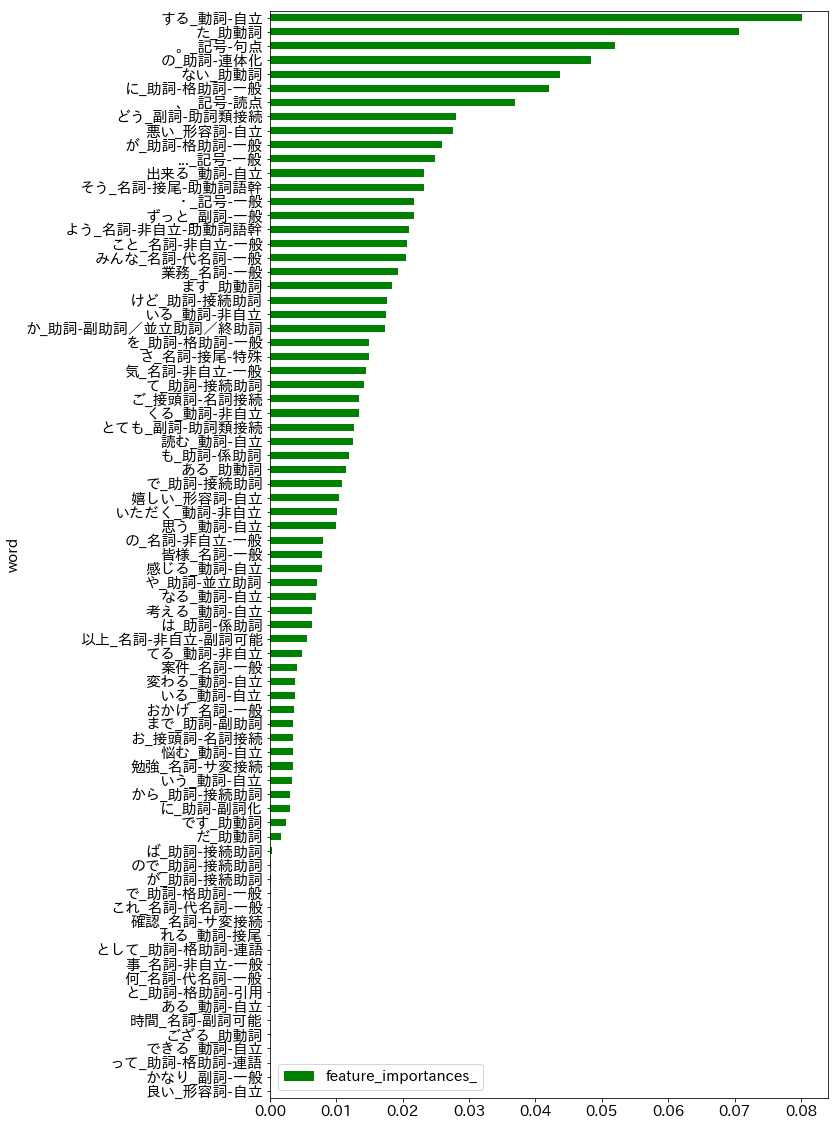

In [23]:
# 横棒グラフ作成
plt.rcParams["font.size"] = 15
asc_feature_importances_df.plot.barh(figsize=(10,20),align='center', color='green')

## 予測データを正解データと紐付け、予測が外れた文書の内容を確認できるデータフレームを作成

In [24]:
# 確認&考察
test_X
# 残念ながらindex番号=内容_idではない
# よって教師データ、予測データを連結される際にはindex番号をキーにして連結させるjoin関数を使用することにする

,以上_名詞-非自立-副詞可能,と_助詞-格助詞-引用,・_記号-一般,気_名詞-非自立-一般,これ_名詞-代名詞-一般,悪い_形容詞-自立,いう_動詞-自立,で_助詞-格助詞-一般,てる_動詞-非自立,ずっと_副詞-一般,...,ある_助動詞,から_助詞-接続助詞,事_名詞-非自立-一般,が_助詞-接続助詞,として_助詞-格助詞-連語,業務_名詞-一般,変わる_動詞-自立,で_助詞-接続助詞,悩む_動詞-自立,ので_助詞-接続助詞
22,0.000000,0.125919,0.0,0.136193,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.150674,0.0,0.0,0.0
20,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.421888,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
25,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.000000,0.705146,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
10,1.054719,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
15,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
28,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
11,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.476676,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


In [25]:
test_X.shape

(8, 77)

In [26]:
# まずは、test_Xに教師データの紐付けから行う
# [内容ID]×[単語＋教師データ]のデータフレームを紐付ける
supervised_df = model_merge_id_df[['text', 'posi_nega']]
test_X_supervised_join_df = test_X.join(supervised_df, how='left')
test_X_supervised_join_df

,以上_名詞-非自立-副詞可能,と_助詞-格助詞-引用,・_記号-一般,気_名詞-非自立-一般,これ_名詞-代名詞-一般,悪い_形容詞-自立,いう_動詞-自立,で_助詞-格助詞-一般,てる_動詞-非自立,ずっと_副詞-一般,...,事_名詞-非自立-一般,が_助詞-接続助詞,として_助詞-格助詞-連語,業務_名詞-一般,変わる_動詞-自立,で_助詞-接続助詞,悩む_動詞-自立,ので_助詞-接続助詞,text,posi_nega
22,0.000000,0.125919,0.0,0.136193,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.150674,0.0,0.0,0.0,変化があると言われていた気がするけど、変わっているように見えない。期待して損した,0
20,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.421888,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,行くっていったけど家を出たくない,0
25,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,良い子はこういう大人になっていはいけない。,0
4,0.000000,0.000000,0.0,0.000000,0.705146,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,これが私の最適化,1
10,1.054719,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,10歳以上若い判定,1
15,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,正直精度自体はよくなかった,0
28,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,夕方ごろに検証用コードにミスを見つけてしまう。,0
11,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.476676,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,2週連続での出展お疲れ様でした,1


In [27]:
test_X_supervised_join_df.shape

(8, 79)

In [28]:
# 次に単語カラムを除外し、予測した結果を格納したカラムを新規で作成する
test_X_supervised_pred_join_df = test_X_supervised_join_df[['text', 'posi_nega']]# 単語カラムを除外
test_X_supervised_pred_join_df['pred'] = pred_y# 新規カラムに予測した結果を格納
test_X_supervised_pred_join_df

# 完成

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,text,posi_nega,pred
22,変化があると言われていた気がするけど、変わっているように見えない。期待して損した,0,0
20,行くっていったけど家を出たくない,0,1
25,良い子はこういう大人になっていはいけない。,0,1
4,これが私の最適化,1,0
10,10歳以上若い判定,1,1
15,正直精度自体はよくなかった,0,1
28,夕方ごろに検証用コードにミスを見つけてしまう。,0,1
11,2週連続での出展お疲れ様でした,1,1
